## This is notebook loads the TPU model and can then generates predictions for sequences and use this to evaluate its performance


### - The saved model weights for the TPU model can be found on Zenodo (Complex Media : https://zenodo.org/record/4436477/files/complex_media_fitness_function.h5?download=1 , Defined Media : https://zenodo.org/record/4436477/files/defined_media_fitness_function.h5?download=1) in addition to the directories referenced in the code (accessible from CodeOcean and the GCP vm)

#### Important Note for the  Readers : 
- Our test datasets in the manuscript (for example the ones used in Fig. 1b,c, Extended Data Fig. 2, Supplementary Fig. 4, etc. ) are not simply held-out subsets of the training datasets. They are separate test datasets generated as part of completely independent experiments with lower-complexity (~1000 fold lower sequence diversity) libraries than the large-scale training data generation experiments resulting in expression measurements with a low measurement-error. The test data used here can be found in the `../../../data/test_data/` folder relative to this notebook's current directory.
- Since the training data and the test data are collected in different experiments, the units of expression are on different unrelated scales (the units are arbitrary units local to experiments and not absolute comparable units across experiments) because of the nature of GPRA/Sort-seq experiments.


### Imports

In [126]:

import sys
import rr_aux
from rr_aux import *
#%load_ext autoreload
#%autoreload 2
##Clear Memory 
tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()
##

rcParams['pdf.fonttype'] = 42


### Load TPU model 
Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency. But, simply changing the model_conditions variable below should allow the user to the load the defined media model.

In [127]:
model_conditions='Glu' # options : 'Glu'# 'Glu' refers to complex media, 'SC_Ura' refers to defined media

NUM_GPU = len(get_available_gpus())
if(NUM_GPU>0) :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

print(tf.__version__)
print(keras.__version__)
#tpu_grpc_url = TPUClusterResolver(tpu=['edv-tpu2'] , zone='us-central1-a').get_master()




### Load the Model in a separate graph here as there are two models in this figure.
fitness_function_graph = tf.Graph()
with fitness_function_graph.as_default():
    model, scaler,batch_size = load_model(model_conditions)

1.14.0
2.2.4-tf


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Full Native All Chunks
- This is the grand test set of all native chunks of promoter DNA, chunked into 80bp regions



### Load Data

In [167]:
if 0 : 
    def population_remove_flank(population) : 
        return_population = []
        for i in range(len(population)): 
            return_population= return_population + [(population[i][17:-13])]
        return return_population

    def population_add_flank(population) : 
        left_flank = ''.join(['T','G','C','A','T','T','T','T','T','T','T','C','A','C','A','T','C'])
        right_flank = ''.join(['G','G','T','T','A','C','G','G','C','T','G','T','T'] )
        population = copy.deepcopy(population)
        for ind in range(len(population)) :
            if not population[ind]!=population[ind]:#math.isnan(population[ind]):       
                population[ind] =  left_flank+ ''.join(population[ind]) + right_flank
            else :
                print(ind)

        return population


    native_specific_chunks_df = pd.read_csv('../../../data/native_sequences_only/nativeChunks.2.uniq.txt', sep = '\t', header = None)

    native_specific_chunks = list(population_add_flank( native_specific_chunks_df[0].values))

    native_df = pd.read_csv('../../../data/native_sequences_only/allNativechunks_measurements.txt.gz',sep= '\t' )
    native_df = native_df[native_df.isNative]
    native_df = native_df[~np.isnan(native_df['EL.combined'])]
    native_df = native_df[native_df['EL.combined']>0]
    expressions = np.array(list(native_df['EL.combined'].values))


    native_all_chunks = [i[3:-7] for i in native_df.seq]
    native_df['seq110'] = native_all_chunks
    sequences = native_all_chunks

    specific_indices = native_df.seq110.isin(native_specific_chunks).values


    native_df['Measured Expression'] = native_df['EL.combined']

    df = native_df[['seq110','Measured Expression']].reset_index()

    df = df[['seq110','Measured Expression']]

    df.to_csv('../reproduce_test_data_performance/All_promoter_fragments_Native.csv')
    
else : 
    df = pd.read_csv('../reproduce_test_data_performance/All_promoter_fragments_Native.csv',
           index_col = 0)
    sequences = list(df.seq110)
    expressions = list(df['Measured Expression'])


### Predict expression using the model

In [166]:
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

61440/61440 [==============================] - 42s 684us/sample


### Compute Spearman's r

In [168]:

pcc = scipy.stats.spearmanr(predicted_expressions,expressions, nan_policy='omit')[0]
print(f'The Spearman\'s r for the Native test data (all chunks) is', format(pcc, '0.3f'))

### Uncomment the next line to get the Pearson's r for more decimal places
#print(f'The Pearson\'s r for the Random test data is', format(pcc)) ### Keen readers will note that this value was used in Notebook 3 of the benchmarking models


The Spearman's r for the Native test data (all chunks) is 0.946


### Compute Pearson's r

In [169]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Native test data (all chunks) is', format(pcc, '0.3f'))

### Uncomment the next line to get the Pearson's r for more decimal places
#print(f'The Pearson\'s r for the Random test data is', format(pcc)) ### Keen readers will note that this value was used in Notebook 3 of the benchmarking models


The Pearson's r for the Native test data (all chunks) is 0.963


### Plot

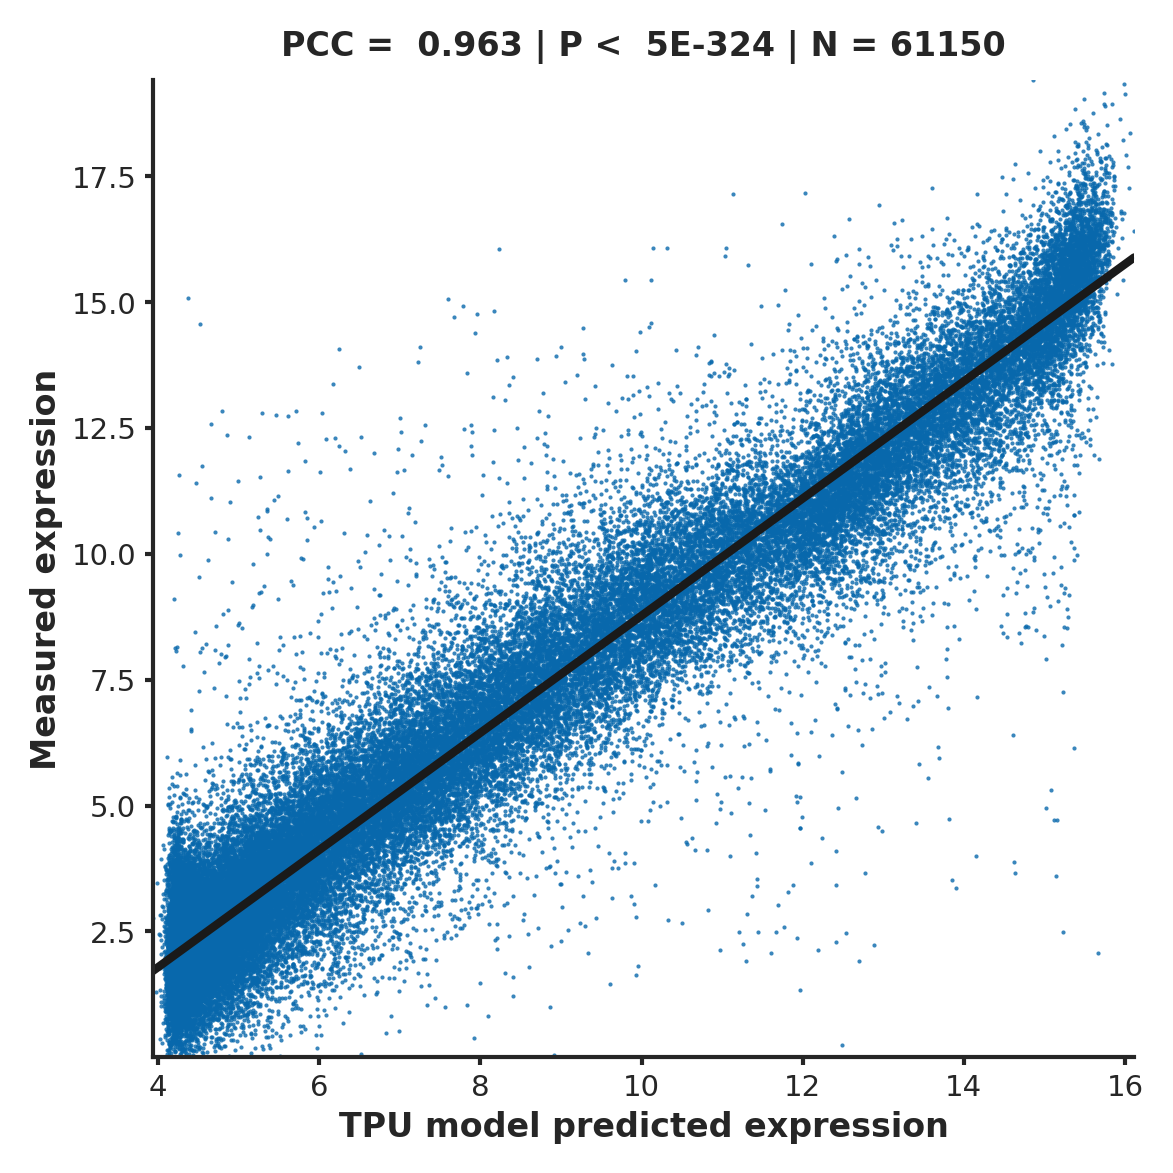

In [125]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_native_allchunks"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
if 1 : 
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':2} ,
                color= '#0868ac', robust = 1 )

else : 
    sns.scatterplot(x,y, s = 1 , linewidth = 0 , rasterized = 1,
               color= '#0868ac')


ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)




plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [124]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Native_allchunks_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985
61148,TGCATTTTTTTCACATCAGAAAAAAAAAATTCTCGGCACGCAAGAC...,16.012221,15.247513


# Random Test Data

### Load random test data

#####  ‘Random Test Data’ definition: 
This test dataset is a a fresh random sample of sequences from the complete sequence space whose expression is measured in the complex medium separately of the training data generation experiment allowing for high quality expression measurements. 


In [101]:
fig_df = pd.read_csv('../../../results_summary/Random_testdata_complex_media.csv' , index_col =0)
    
    

### Generate expression predictions using the TPU model

In [103]:
### %%time  
### This can take up to a minute for the GPU model

sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['Measured Expression'].values) # Load expressions



predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

3072/3072 [==============================] - 2s 691us/sample


### Compute and Print the Pearson's r between Measured and Predicted expression


In [106]:

pcc = scipy.stats.spearmanr(predicted_expressions,expressions)[0]
print(f'The Spearman\'s r for the Random test data is', format(pcc, '0.3f'))

### Uncomment the next line to get the Pearson's r for more decimal places
#print(f'The Pearson\'s r for the Random test data is', format(pcc)) ### Keen readers will note that this value was used in Notebook 3 of the benchmarking models


The Spearman's r for the Random test data is 0.976


In [107]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Random test data is', format(pcc, '0.3f'))

### Uncomment the next line to get the Pearson's r for more decimal places
#print(f'The Pearson\'s r for the Random test data is', format(pcc)) ### Keen readers will note that this value was used in Notebook 3 of the benchmarking models


The Pearson's r for the Random test data is 0.978


#### Plot the scatterplot to visualize the prediction performance 


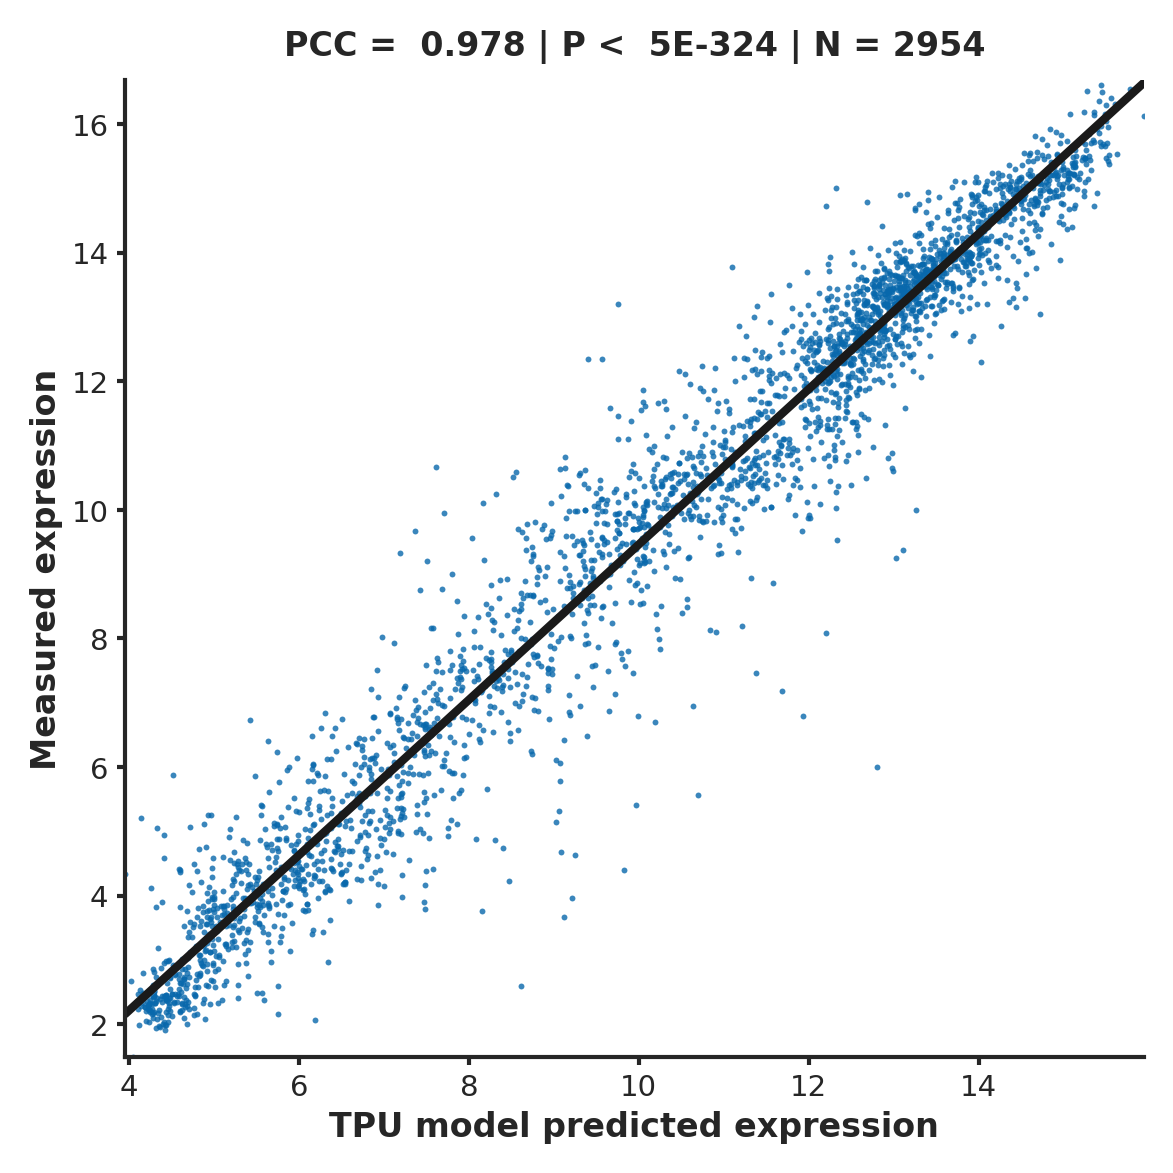

In [110]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':2,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [109]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Random_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,NNNNNNNNNNTGCATTTTTTTCACAAGAGCACTTGAAGGGCGCCTA...,13.708592,13.144622
1,NNNTGCATTTTTTTCACACATATACTTGGGTGACTTAGATATTTGC...,2.553335,4.590216
2,NTGCATTTTTTTCACACATCTGGATTGTCTGGTGTGCTGGTATCTT...,13.369969,13.149384
3,NNNNNTGCATTTTTTTCACACTCAGACTTCCACGTTTTGTGGGTCT...,3.785646,7.482493
4,NTGCATTTTTTTCACACTGAGCCTTGCAAAAAGGGTTGTATTGCGT...,10.367365,10.063116
...,...,...,...
2949,NNTGCATTTTTTTCACTCTTGCTGCGTGCGAGCTTAATGCGCGTCG...,15.666411,15.486315
2950,NNTGCATTTTTTTCACTCTTTCACGTGGGGCCTGCGGGGTATCGGT...,14.962475,15.238556
2951,TGCATTTTTTTCACTTCCAGTAATATGCGAAAGGGTGATGTGAACT...,4.541188,6.266724
2952,NNNNNNNNNNNNNNTGCATTTTTTTCACTTCGCACTCCACTTCTCG...,7.456650,11.376089


# Native Test Data 

### Load native test data 

#####  ‘Native Test Data’ definition: 
This test dataset corresponds to a set of native yeast promoter sequences from the S288C reference genomes measured in the complex medium. As above, they are measured in an experiment separate from the large training data generation experiment. 



In [128]:
#native_df = pd.read_csv('../../../data/test_data/Native_testdata.csv', index_col = 0 )

###Extract sequences corresponding to native sequences in the defined medium
full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')

if 1 : 

    #fig_df = full_df[(full_df.native==1) & (full_df.expt=='NBT_S288CdU_YPD') ]#(snp_df.randMut) &
    fig_df = full_df[(full_df.nativeMut==1) & (full_df.expt=='NBT_S288CdU_YPD') ]#(snp_df.randMut) &

    native_df = fig_df
### Extract native sequences and their derived mutants
else : 
    fig_df = full_df[full_df.origID.str.contains('Y') &
            (full_df.expt=='NBT_S288CdU_YPD')
           ]
    
    native_df = fig_df

### Generate expression predictions using the TPU model


In [129]:
sequences = list(native_df.seq110.values) ### sequence
expressions= list(native_df.meanEL) ### measured expression


### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

4096/4096 [==============================] - 3s 832us/sample


### Compute and Print the Pearson's r between Measured and Predicted expression


In [130]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Native test data is', format(pcc, '0.3f'))


The Pearson's r for the Native test data is 0.961


### Plot the results

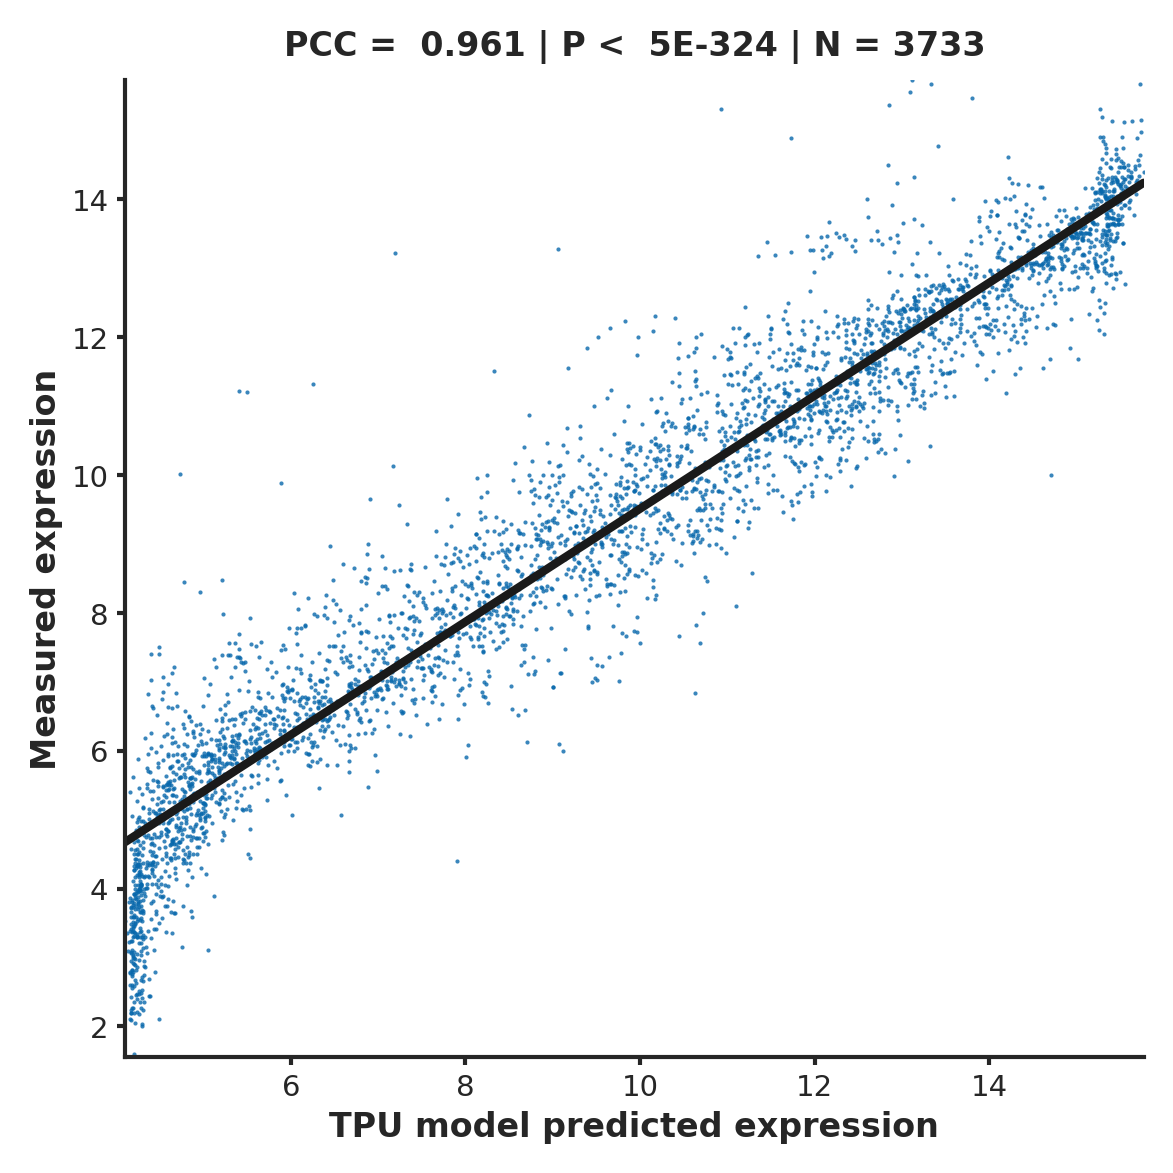

In [131]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_native"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [132]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Native_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGG...,13.168816,14.333738
1,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAACAAAAAGG...,13.457919,14.332550
2,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGA...,13.855758,14.495706
3,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,12.043120,13.306715
4,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,13.529583,14.713246
...,...,...,...
3728,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.344921,7.655699
3729,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,6.589246,5.922864
3730,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.740563,6.864065
3731,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCCTTATTCT...,7.421802,6.316618


# Reproduce the random mutational drift validation experiment prediction result  corresponding to Figure  2a-c using the TPU model's predictions

Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency. 

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own. 
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets
##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [133]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to random drift in the complex medium
    fig_df = snp_df.loc[(snp_df.rand) & (snp_df.expt=='NBT_S288CdU_YPD')] #(snp_df.randMut) &

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/Drift_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/Drift_testdata.csv' , index_col =0)

### Generate expression predictions using the TPU  model

In [134]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL.mut'].values) # Load expressions

### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

3072/3072 [==============================] - 2s 714us/sample


### Compute and Print the Pearson's r between Measured and Predicted expression

In [135]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Random Drift test data (corresponding to the section for Fig 2a-c) is', format(pcc, '0.3f'))


The Pearson's r for the Random Drift test data (corresponding to the section for Fig 2a-c) is 0.974


In [136]:

pcc = scipy.stats.spearmanr(predicted_expressions,expressions)[0]
print(f'The Spearman\'s r for the Random Drift test data (corresponding to the section for Fig 2a-c) is', format(pcc, '0.3f'))


The Spearman's r for the Random Drift test data (corresponding to the section for Fig 2a-c) is 0.981


### Plot the results 
Readers familiar with the biorxiv version of our manuscript will notice that the value of N in the final version is half the value of N in the biorxiv version. This is was our mistake ( we combined two dataframes previously when making this plot, and used the combined df to compute the N instead of the original one). This has been corrected and the correct version of N is shown in the final version (and below). This did not affect the Pearson's r calcultion of the P value in any way ( and the readers will notice that it remains the same - those were computed independently of the N, as shown below)

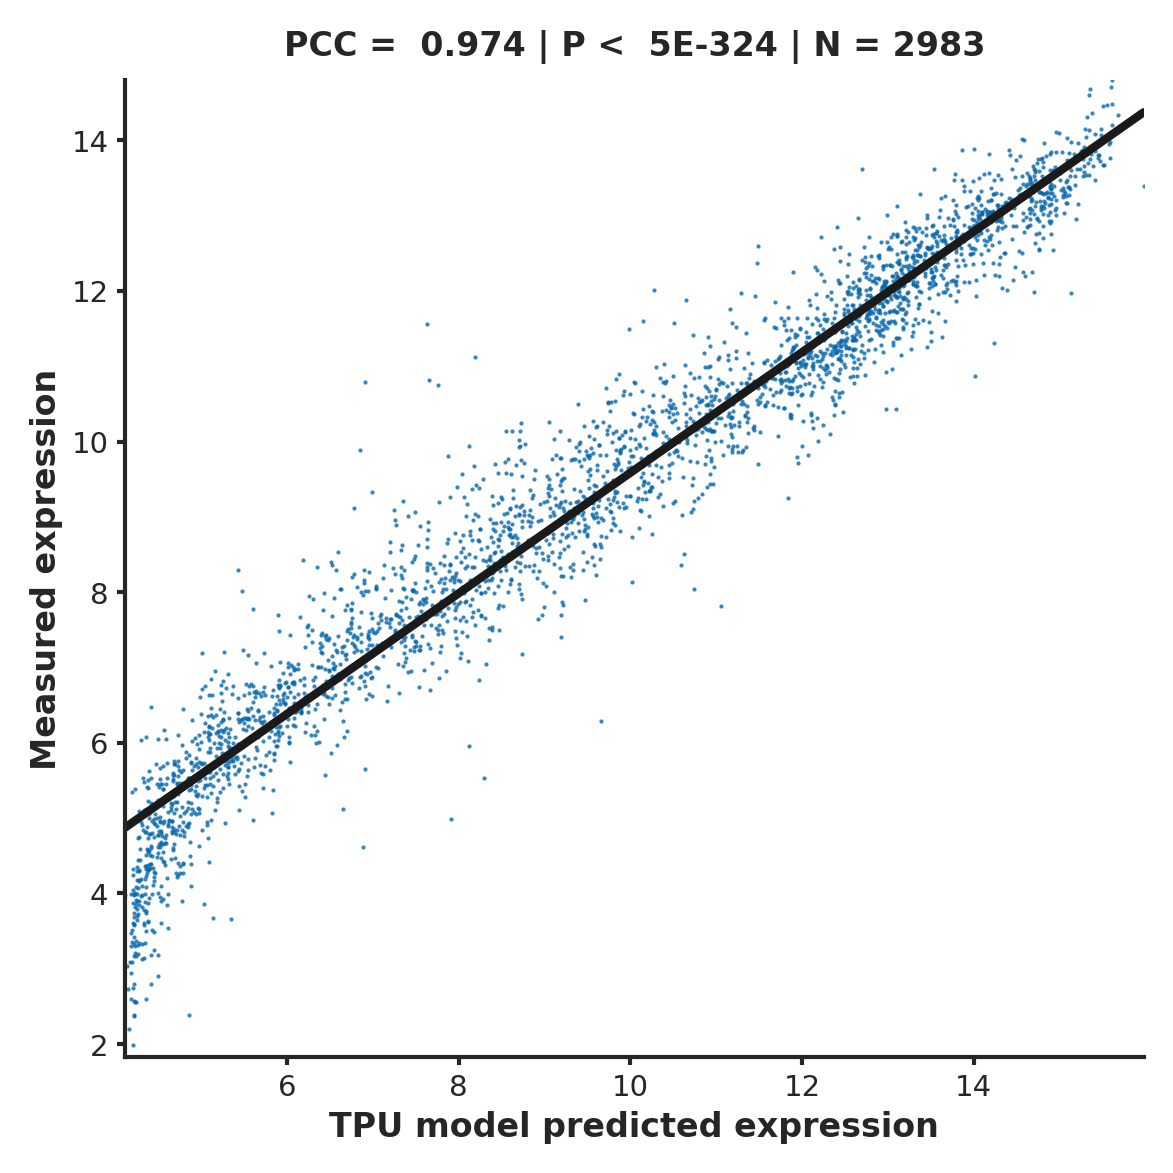

In [16]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_drift"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [17]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Drift_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACGGCGC...,11.278011,12.921628
1,TGCATTTTTTTCACATCCTTTAAATTCGGTGGGGACGCGTCGGCGC...,11.725461,13.208659
2,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACCGCGC...,11.725053,13.091141
3,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGAGGACAGTC...,9.008385,10.215848
4,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGACGACAGTC...,10.695459,11.634071
...,...,...,...
2978,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTATGAATATCGTAAC...,12.134682,13.292812
2979,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTACGAGTATCGTAAC...,13.562228,14.617356
2980,TGCATTTTTTTCACATCGGAACGTTAACATCAATCCGGTCACCACG...,10.788450,11.057049
2981,TGCATTTTTTTCACATCGGAACGTTAATATCCATCCGGTCACCACG...,12.423164,13.211720


# Reproducing the SSWM validation experiment prediction result  corresponding to Figure  2e-g using the TPU model's predictions 

Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media TPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [137]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to SSWM in the complex medium
    
    fig_df =full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')]
    fig_df.loc[fig_df.trajDir=='dec' , 'trajDir'] = 'min'
    fig_df.loc[fig_df.trajDir=='inc','trajDir'] = 'max'

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/SSWM_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/SSWM_testdata.csv' , index_col =0)

### Generate expression predictions using the TPU only model


In [138]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

11264/11264 [==============================] - 8s 703us/sample


### Compute and Print the Pearson's r between Measured and Predicted expression

In [139]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the SSWM test data (corresponding to the section for Fig 2e-f) is', format(pcc, '0.3f'))


The Pearson's r for the SSWM test data (corresponding to the section for Fig 2e-f) is 0.981


In [140]:

pcc = scipy.stats.spearmanr(predicted_expressions,expressions)[0]
print(f'The Spearman\'s r for the SSWM test data (corresponding to the section for Fig 2e-f) is', format(pcc, '0.3f'))


The Spearman's r for the SSWM test data (corresponding to the section for Fig 2e-f) is 0.923


### Plot the results 

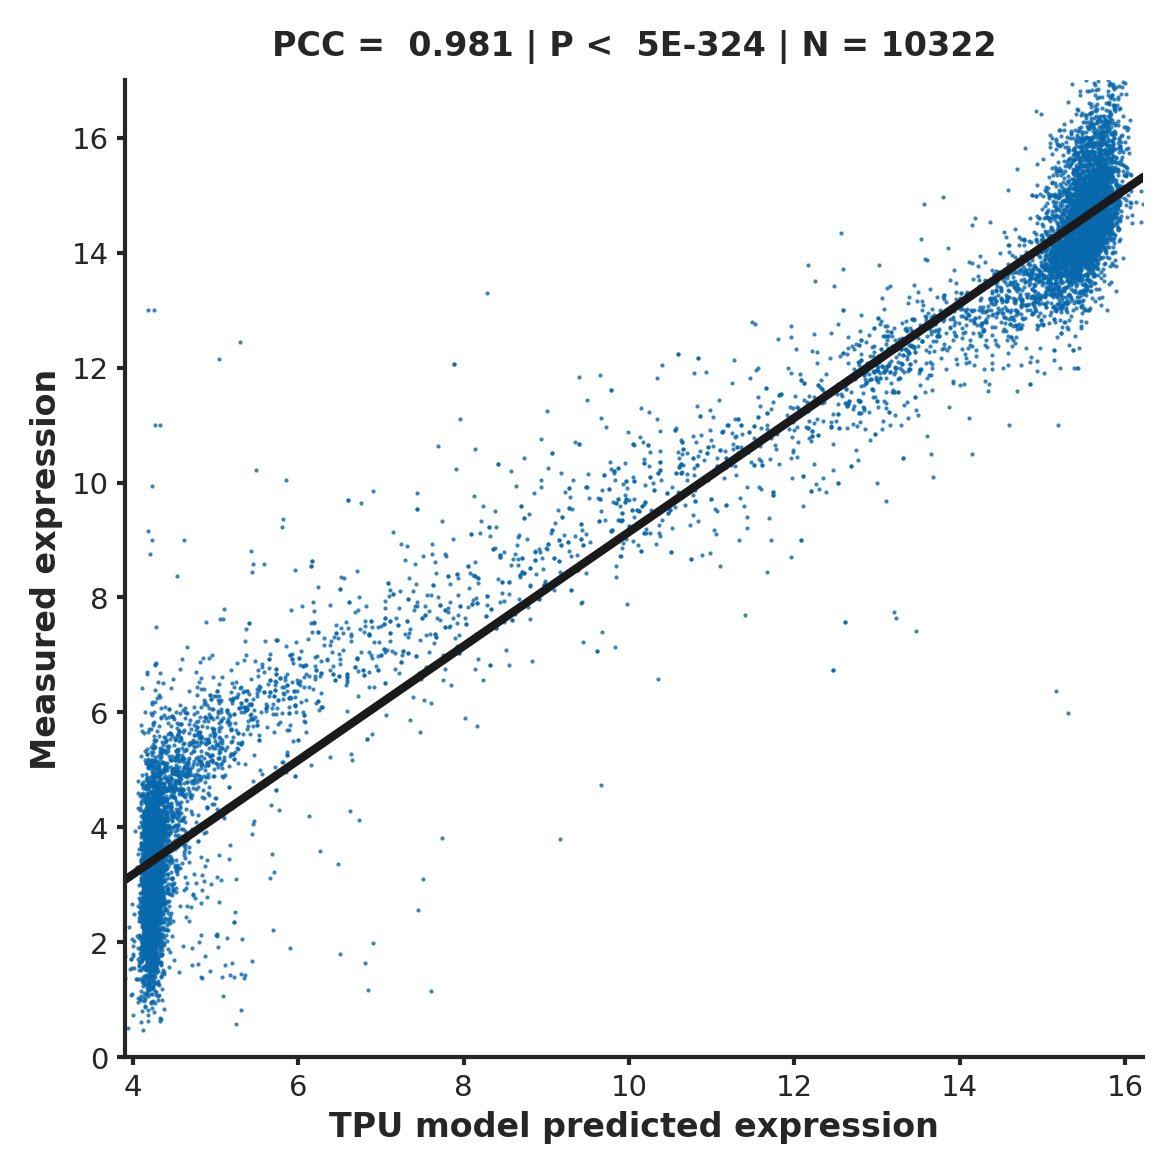

In [21]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_sswm"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [22]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/SSWM_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.000000,11.353749
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,14.000000,15.208617
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.000000,15.420066
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAGAATTCGCGCATTT...,15.783623,15.327061
...,...,...,...
10317,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,15.644227,15.528503
10318,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.604007,15.545308
10319,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,14.581721,15.556981
10320,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,13.727267,15.543314


# Prediction results corresponding to (the Genetic Algorithm panel ) using the TPU model's predictions vs the measured expression 

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [23]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to random drift in the complex medium


    fig_df = full_df[(full_df.expt=='NBT_S288CdU_YPD') &   
                              (full_df.designedCond=='Glu')&  
                              (full_df.designed==1)]

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/ga_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/ga_testdata.csv' , index_col =0)

### Generate expression predictions using the GPU only model

In [24]:
sequences = list(fig_df.seq110.values) ### sequence
expressions = list(fig_df['meanEL'].values) # Load expressions

### Predict Expression
predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)

1024/1024 [==============================] - 1s 771us/sample


In [25]:

pcc = scipy.stats.pearsonr(predicted_expressions,expressions)[0]
print(f'The Pearson\'s r for the Genetic Algorithm test data (corresponding to the section for Fig 1d) is', format(pcc, '0.3f'))


The Pearson's r for the Genetic Algorithm test data (corresponding to the section for Fig 1d) is 0.993


### Plot the results 

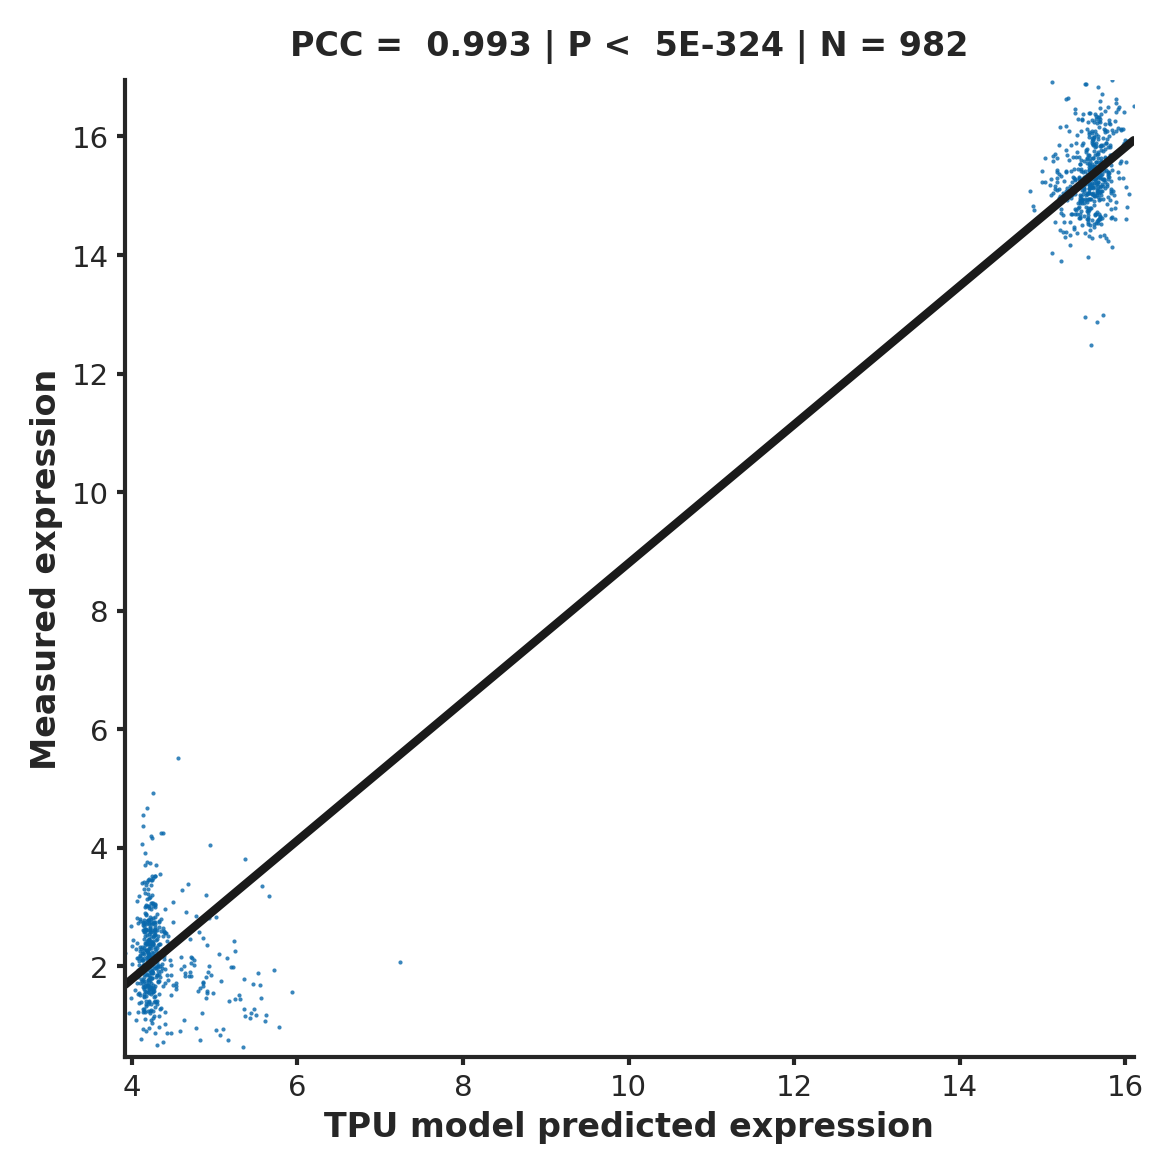

In [26]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_ga"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(predicted_expressions)
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [27]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/ga_test_tpu_model.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAGGCTATTTGATATGTTAAAAGAAGG...,1.244706,4.143212
1,TGCATTTTTTTCACATCAAACAATCTCTTGATGTGTCAGAAATAAG...,0.980188,4.331097
2,TGCATTTTTTTCACATCAAACAATGGGTTGTCATCTTCTAAGATAG...,2.764484,4.326525
3,TGCATTTTTTTCACATCAAACTATTGTTAGATGTCAAATGAACTAC...,1.414264,4.208059
4,TGCATTTTTTTCACATCAAACTCTATCATTTCTGCAGAGGTTGCAA...,2.241734,4.199040
...,...,...,...
977,TGCATTTTTTTCACATCTTTTGATATAACCTGGTCGAATATACTAT...,3.232783,4.162705
978,TGCATTTTTTTCACATCTTTTGCAACTATTTCACCAAATGGTATCC...,3.432195,4.147635
979,TGCATTTTTTTCACATCTTTTGTAATAGTAGATGTCAATGGGATAG...,3.305018,4.145849
980,TGCATTTTTTTCACATCTTTTTCCGGGTGACGGCGCGACTTTGTGC...,15.260873,15.632592


# Gini Trajectories

### Save Results

In [28]:
import glob
file_list = glob.glob('../../../data/test_data/all_gini_trajectories/*')[:-1]



for i in [-1,1,-2,2,0]: 
    gini_df = pd.read_csv( file_list[i], 
                          sep='\t')
    sequences = population_add_flank(list(gini_df['N80seq'].values))
    expressions = gini_df['meanEL_NBT_S288CdU_YPD'].values
    predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)


    results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})

    results_df.to_csv('../../../results_summary/'+file_list[i].split('/')[-1]+'_tpu_model.csv')

1024/1024 [==============================] - 1s 731us/sample


### Plot Results

1024/1024 [==============================] - 1s 741us/sample


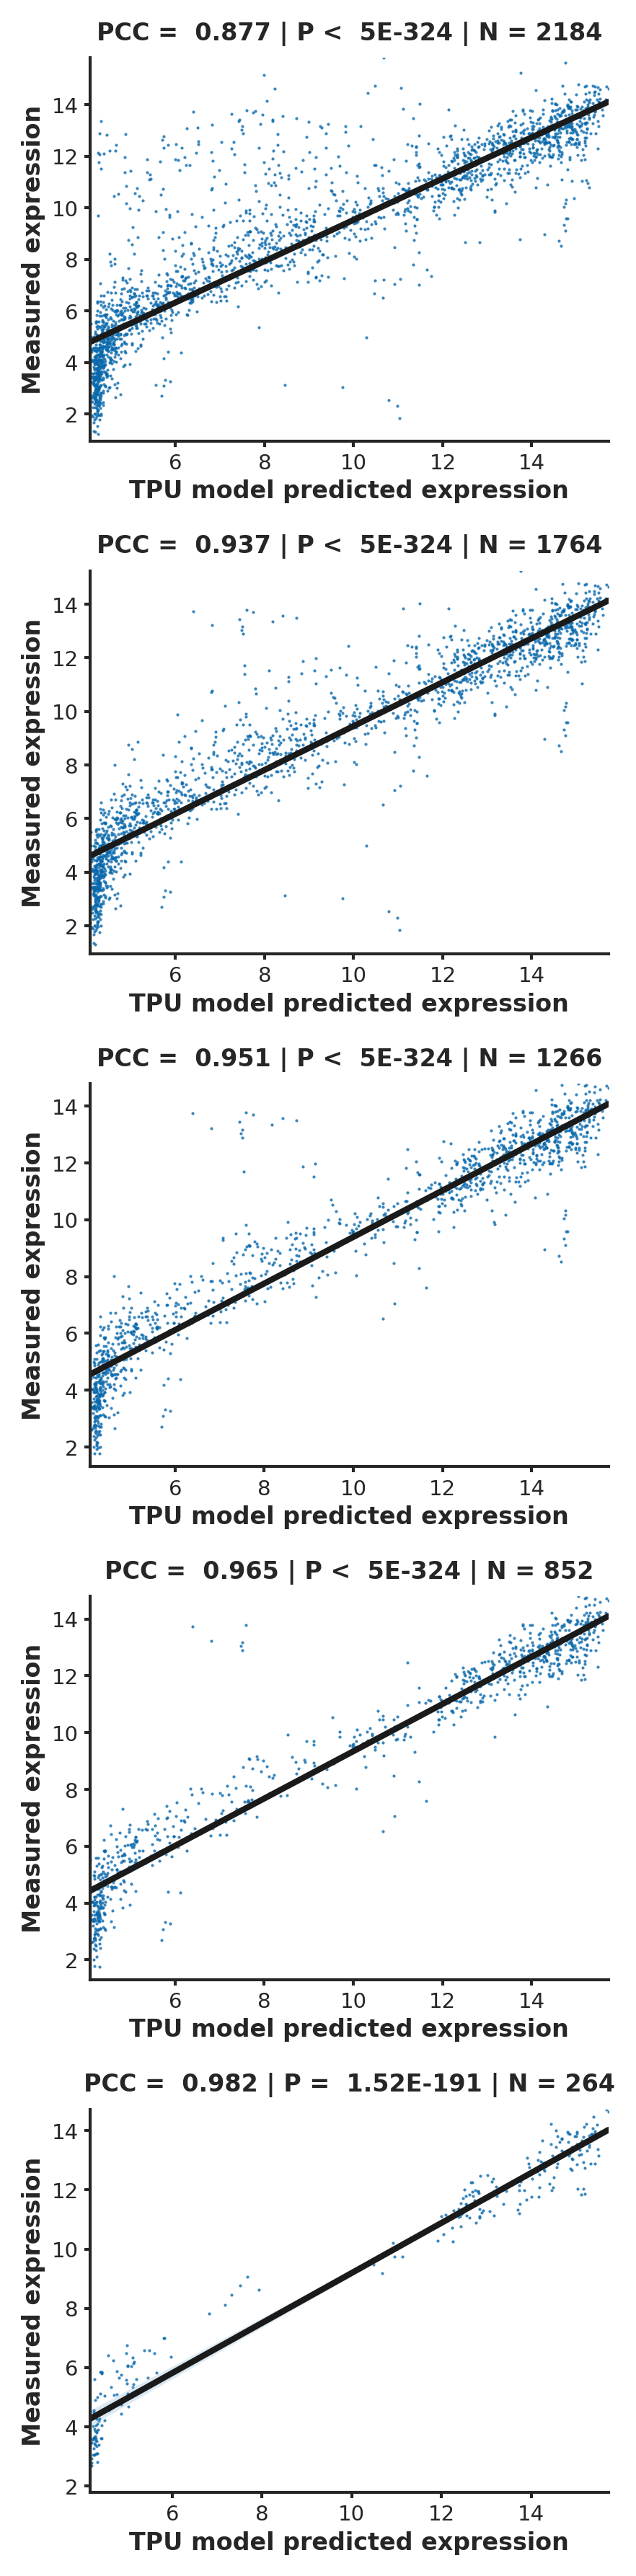

In [29]:
import glob
file_list = glob.glob('../../../data/test_data/all_gini_trajectories/*')[:-1]


model_name = 'TPU model'

fig_file = model_name+" prediction_performance_gini"

fig=plt.figure(figsize=(12/4,12) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


index = 1
for i in [-1,1,-2,2,0]: 
    plt.subplot(5, 1, index)
    index = index+1
    gini_df = pd.read_csv( file_list[i], 
                          sep='\t')
    sequences = population_add_flank(list(gini_df['N80seq'].values))
    expressions = gini_df['meanEL_NBT_S288CdU_YPD'].values
    predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)
    x = list(predicted_expressions)
    y = expressions

    
    
    
    
    
    r = scipy.stats.pearsonr(x ,y )
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':2} ,
                color= '#0868ac', robust = 1 )



    ax = plt.gca()
    #ax.get_legend().remove()


    ax.set_xlabel(model_name + " predicted expression")
    ax.set_ylabel("Measured expression")
    if (r[1] ==0.0) :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
    else :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


    plt.setp(ax.artists, edgecolor = 'k')
    plt.setp(ax.lines, color='k')
    #plt.setp(ax.lines, linewidth=1.5)

    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    #ax.set_xlim(xmin=-8,xmax=8)
    #ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()


# Mean-vs-mean SSWM
Reproducing the SSWM validation experiment prediction result (Extended Data Fig. 2i) corresponding to Figure  2e-g using the TPU model's predictions 

Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media TPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [30]:
if 0 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to SSWM in the complex medium
    
    fig_df =full_df[(full_df.trajOpt=='Glu') & (full_df.expt=='NBT_S288CdU_YPD')]
    fig_df.loc[fig_df.trajDir=='dec' , 'trajDir'] = 'min'
    fig_df.loc[fig_df.trajDir=='inc','trajDir'] = 'max'

    ### Save to file for convenience of readers
    fig_df.to_csv('../../../results_summary/SSWM_testdata.csv')
    
else :
    fig_df = pd.read_csv('../../../results_summary/SSWM_testdata.csv' , index_col =0)

### Generate expression predictions using the TPU  model


In [31]:


if 1:
    sequences = list(fig_df.seq110.values) ### sequence
    expressions = list(fig_df['meanEL'].values) # Load expressions

    ### Predict Expression
    predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)
    fig_df['edvPred_gpu'] = predicted_expressions


min_df = fig_df[fig_df.trajDir == 'min'].groupby('ED').mean()
y_min = min_df.loc[:,['meanEL']].values.flatten()
x_min = min_df.loc[:,['edvPred_gpu']].values.flatten()

max_df = fig_df[fig_df.trajDir == 'max'].groupby('ED').mean()
y_max = max_df.loc[:,['meanEL']].values.flatten()
x_max = max_df.loc[:,['edvPred_gpu']].values.flatten()

df = pd.DataFrame(index = min_df.index, data = {'Predicted Expression' : x_min , 
                                          'Measured Expression' : y_min,
                                          'Direction' : 'Minimizing'} )

df = df.append(pd.DataFrame(index = max_df.index, data = {'Predicted Expression' : x_max , 
                                          'Measured Expression' : y_max,
                                          'Direction' : 'Maximizing'} ))

11264/11264 [==============================] - 8s 733us/sample


### Compute and Print the Pearson's r between Measured and Predicted expression

In [32]:

pcc = scipy.stats.pearsonr(df['Measured Expression'],df['Predicted Expression'])[0]
print(f'The Pearson\'s r is', format(pcc, '0.3f'))


The Pearson's r is 0.996


### Plot the results 

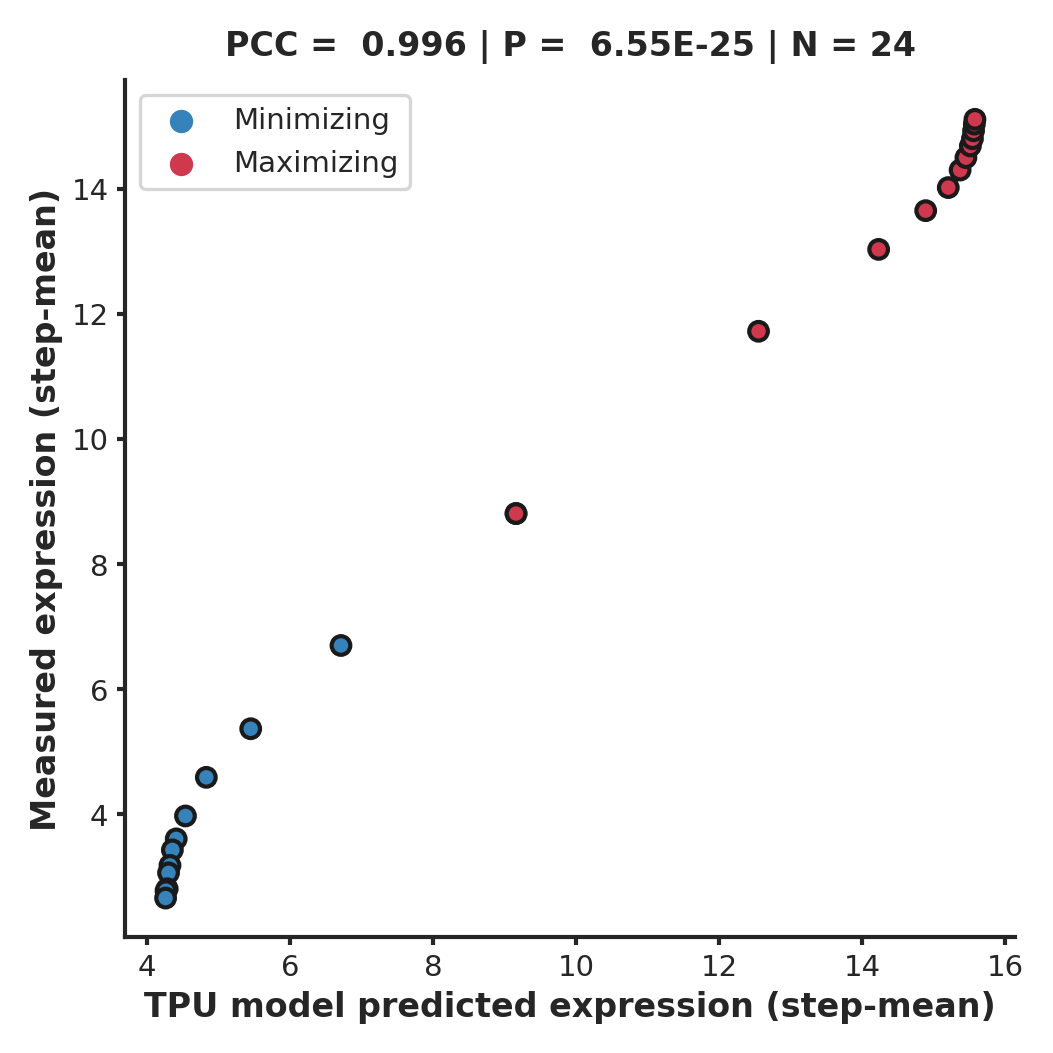

In [33]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_sswm_mean"

fig=plt.figure(figsize=(3.6,3.6) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

custom_rb_color_palette = [sns.color_palette('Spectral_r' , n_colors = 10)[0]  ,
             sns.color_palette('Spectral_r' , n_colors = 10)[-1]]

x = list(df['Predicted Expression'])
y = list(df['Measured Expression'])
c = list(df['Direction'])

r = scipy.stats.pearsonr(x ,y )
sns.scatterplot(x=x ,y=y , hue=c, s= 20 , linewidth=1, rasterized = 1,  color= '#0868ac' , 
               alpha = 1, palette=custom_rb_color_palette , edgecolor= 'k')


ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression (step-mean)")
ax.set_ylabel("Measured expression (step-mean)")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()